Steven Ly - ANN Exercise - 13-3-2024

# Exploratory Data Analysis

I am using a dataset that contains 25k labeled images of natural landscapes from around the world. It is originated from Kaggle.
This dataset contains 25k labeled images of pixel size 150x150, of which the images are divided into 6 categories. The categories are buildings, forest, glacier, mountain, sea, and street. The dataset is foldered into a training set and a test set. The training set contains 14k images and the test set contains 3k images. The images are in jpg format.


The labeling of the images is as follows:
'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 

In [1]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (150, 150)
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

I visualised the amount of images per category to validate that each category has a sufficient amount of images to train the model. To validate that the model is not overfitting, I also visualised the amount of images per category in the test set.

It seems that this dataset has a split of 80% training and 20% test. This seems like a balanced split to train the model and validate it.

In [3]:
print("Number of images in each category of the train set:")
for c in class_names:
    print(f"{c}: {len(os.listdir(os.path.join('seg_train/seg_train', c)))}")

Number of images in each category of the train set:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [4]:
print("Number of images in each category of the test set:")
for c in class_names:
    print(f"{c}: {len(os.listdir(os.path.join('seg_test/seg_test', c)))}")

Number of images in each category of the test set:
buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


# Data Visualization

I visualised the data to get a better understanding of the images in the dataset. For each category I've displayed 3 images.

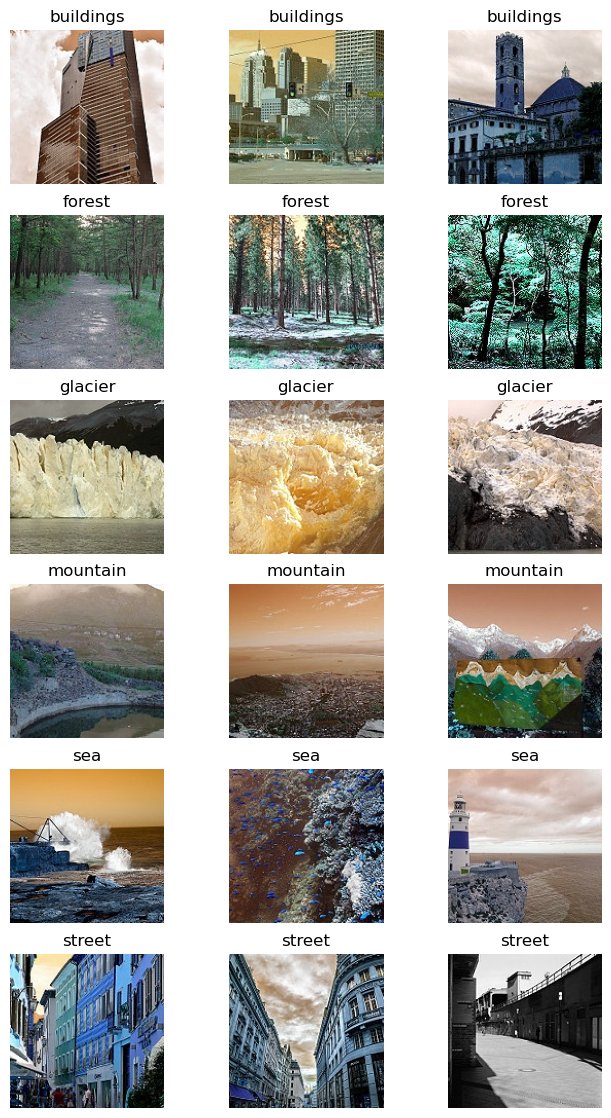

In [5]:
# Define the path to the directory containing the images
base_path = "seg_test/seg_test/"

# Create a figure and axis objects
fig, axes = plt.subplots(6, 3, figsize=(8, 14))

# Loop through each category and display images
for i, cls in enumerate(class_names):
    category_path = os.path.join(base_path, cls)
    image_files = os.listdir(category_path)[:3]
    for j, image_file in enumerate(image_files):
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(cls)

plt.show()

# Data Preprocessing

In this section I will preprocess the data so that my neural network can learn from the images. I have chosen for 40x40 pixels because it should be relatively easy for the model to learn from this size. 

The function ```load_data()``` will load the images and labels from the both the training and test set. 
I added an optional parameter to load the images in grayscale because I am curious if the neural network performs better with colored images. My hypothesis is that the neural network will perform better with colored images since the color of the image can be an important feature to classify the image. For example, images of the sea are usually blue, forests are green and glaciers are white.

In [6]:
img_size = (40, 40)

In [7]:
def load_data(grayscale=False):
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))): # tqdm is used to show the progress of the iteration
                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                if grayscale:
                    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)

                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [8]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
print(f"dimensions: {train_images.shape}")

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:00<00:00, 2622.39it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 2654.24it/s]


dimensions: (14034, 40, 40, 3)


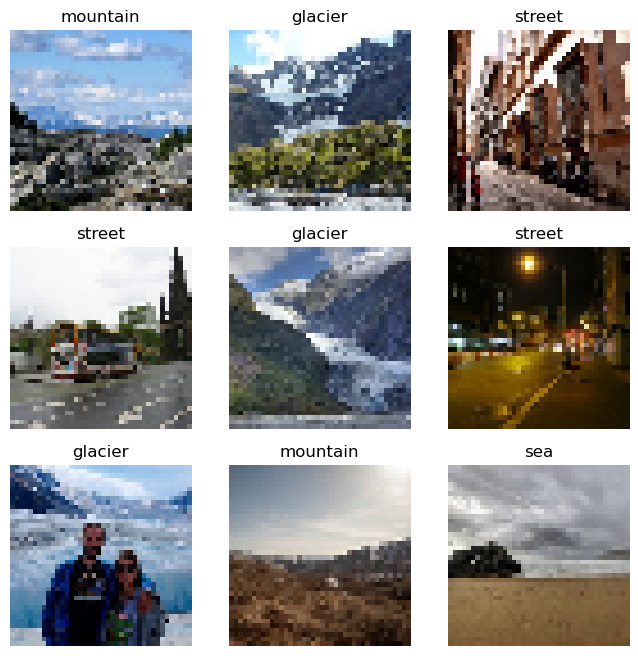

In [9]:
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(class_names[train_labels[i]])
    plt.axis("off")

In [10]:
(g_train_images, g_train_labels), (g_test_images, g_test_labels) = load_data(grayscale=True)
g_train_images, g_train_labels = shuffle(g_train_images, g_train_labels, random_state=25)
print(f"dimensions: {g_train_images.shape}")

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:00<00:00, 2618.70it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 2633.26it/s]


dimensions: (14034, 40, 40)


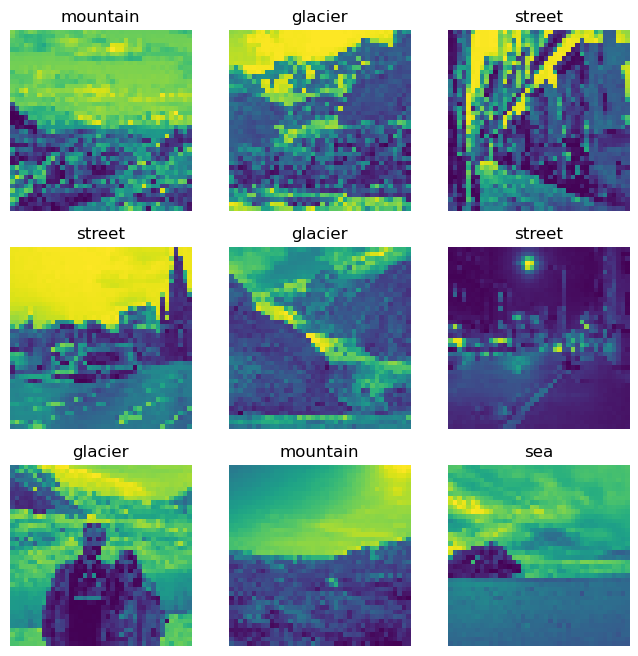

In [11]:
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(g_train_images[i].astype("uint8"))
    plt.title(class_names[train_labels[i]])
    plt.axis("off")

This is a function which plots out the accuracy and loss of the model. This function will be used to visualize the performance of the model.

In [12]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

# Modelling Colored Images

In this section I will train a neural network with the colored images. I have arbitrarily chosen for a neural network with two hidden layers, one with 128 neurons and the other with 64 neurons.

Adam is an optimizer that computes adaptive learning rates for each parameter. 
Adagrad is an optimizer that adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters.

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 16s 44ms/step - loss: 51.7205 - accuracy: 0.3427 - val_loss: 13.0145 - val_accuracy: 0.3951
Epoch 2/10
351/351 [==============================] - 16s 46ms/step - loss: 13.2551 - accuracy: 0.3933 - val_loss: 6.5625 - val_accuracy: 0.4389
Epoch 3/10
351/351 [==============================] - 16s 44ms/step - loss: 4.7056 - accuracy: 0.4077 - val_loss: 2.5281 - val_accuracy: 0.3513
Epoch 4/10
351/351 [==============================] - 16s 46ms/step - loss: 1.6692 - accuracy: 0.4397 - val_loss: 1.6352 - val_accuracy: 0.4585
Epoch 5/10
351/351 [==============================] - 16s 44ms/step - loss: 1.4231 - accuracy: 0.4702 - val_loss: 1.4811 - val_accuracy: 0.4325
Epoch 6/10
351/351 [==============================] - 16s 46ms/step - loss: 1.4815 - accuracy: 0.4583 - val_loss: 2.0797 - val_accuracy: 0.3509
Epoch 7/10
351/351 [==============================] - 16s 45ms/step - loss: 1.4757 - accuracy: 0.4680 - val_loss: 1.4982 - val_accura

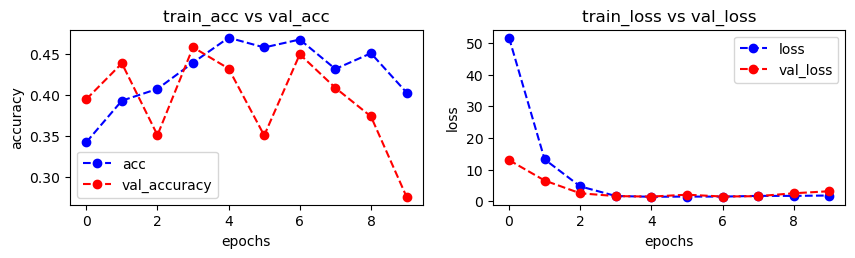

In [25]:
plot_accuracy_loss(history)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adagrad(0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 16s 45ms/step - loss: 34.3452 - accuracy: 0.3308 - val_loss: 19.5147 - val_accuracy: 0.3245
Epoch 2/10
351/351 [==============================] - 16s 45ms/step - loss: 13.4087 - accuracy: 0.3801 - val_loss: 12.4632 - val_accuracy: 0.3566
Epoch 3/10
351/351 [==============================] - 16s 44ms/step - loss: 10.8306 - accuracy: 0.3951 - val_loss: 10.3124 - val_accuracy: 0.4061
Epoch 4/10
351/351 [==============================] - 16s 45ms/step - loss: 9.6009 - accuracy: 0.4055 - val_loss: 9.7151 - val_accuracy: 0.4079
Epoch 5/10
351/351 [==============================] - 16s 45ms/step - loss: 8.8060 - accuracy: 0.4186 - val_loss: 9.1205 - val_accuracy: 0.3929
Epoch 6/10
351/351 [==============================] - 16s 46ms/step - loss: 8.3364 - accuracy: 0.4273 - val_loss: 8.8623 - val_accuracy: 0.4026
Epoch 7/10
351/351 [==============================] - 16s 45ms/step - loss: 7.6931 - accuracy: 0.4398 - val_loss: 8.8683 - val_acc

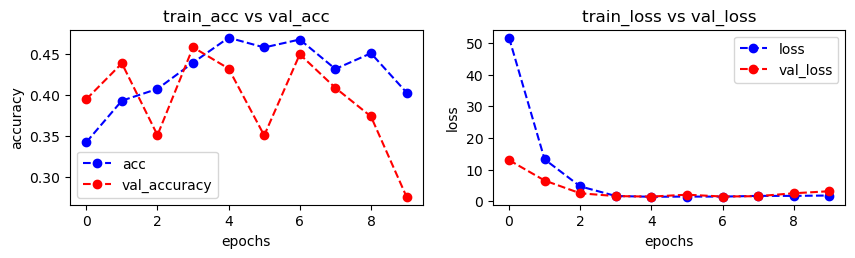

In [24]:
plot_accuracy_loss(history)

# Modelling Grayscale Images

In this section I will train a neural network with the colored images. These networks will have the same parameters and lay-out as the neural networks that are trained on the colored images.

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=g_train_images.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(g_train_images, g_train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 5s 12ms/step - loss: 23.0786 - accuracy: 0.2410 - val_loss: 12.1550 - val_accuracy: 0.2451
Epoch 2/10
351/351 [==============================] - 4s 12ms/step - loss: 8.3176 - accuracy: 0.2800 - val_loss: 5.7637 - val_accuracy: 0.2426
Epoch 3/10
351/351 [==============================] - 4s 12ms/step - loss: 5.7491 - accuracy: 0.2775 - val_loss: 3.6598 - val_accuracy: 0.3010
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 3.0717 - accuracy: 0.3035 - val_loss: 2.3514 - val_accuracy: 0.2508
Epoch 5/10
351/351 [==============================] - 4s 12ms/step - loss: 1.8240 - accuracy: 0.3244 - val_loss: 1.7362 - val_accuracy: 0.3203
Epoch 6/10
351/351 [==============================] - 4s 10ms/step - loss: 1.6141 - accuracy: 0.3566 - val_loss: 1.5939 - val_accuracy: 0.3452
Epoch 7/10
351/351 [==============================] - 4s 11ms/step - loss: 1.5716 - accuracy: 0.3641 - val_loss: 1.7058 - val_accuracy: 0.29

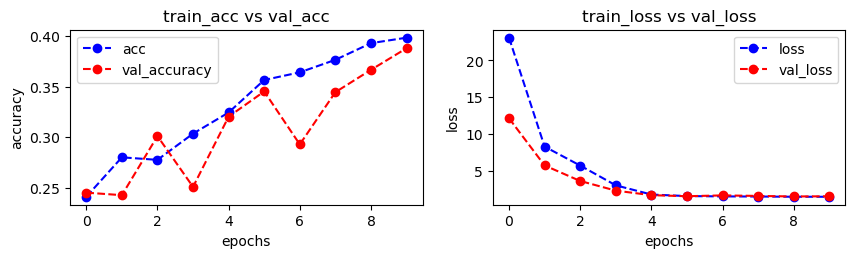

In [20]:
plot_accuracy_loss(history)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=g_train_images.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = tf.keras.optimizers.Adagrad(0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(g_train_images, g_train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 4s 12ms/step - loss: 7.5434 - accuracy: 0.2186 - val_loss: 2.0100 - val_accuracy: 0.2091
Epoch 2/10
351/351 [==============================] - 4s 10ms/step - loss: 1.9616 - accuracy: 0.1985 - val_loss: 1.8899 - val_accuracy: 0.1981
Epoch 3/10
351/351 [==============================] - 4s 12ms/step - loss: 1.8672 - accuracy: 0.2001 - val_loss: 1.8612 - val_accuracy: 0.1970
Epoch 4/10
351/351 [==============================] - 4s 11ms/step - loss: 1.8327 - accuracy: 0.2042 - val_loss: 1.8454 - val_accuracy: 0.1956
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 1.8136 - accuracy: 0.2017 - val_loss: 1.8406 - val_accuracy: 0.1952
Epoch 6/10
351/351 [==============================] - 4s 10ms/step - loss: 1.8003 - accuracy: 0.2031 - val_loss: 1.8354 - val_accuracy: 0.1959
Epoch 7/10
351/351 [==============================] - 4s 11ms/step - loss: 1.7909 - accuracy: 0.2050 - val_loss: 1.8346 - val_accuracy: 0.1959

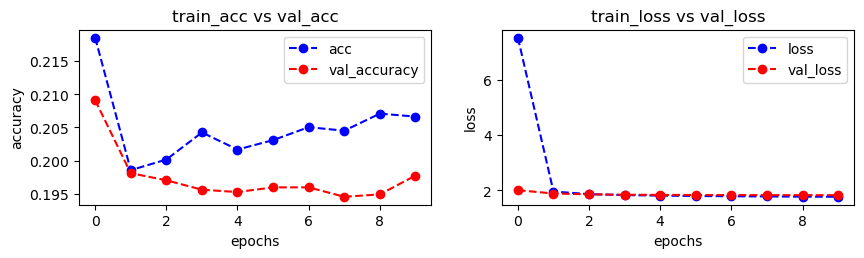

In [22]:
plot_accuracy_loss(history)

# Conclusion

My hypothesis was that the neural network would perform better with colored images. I cannot confirm this hypothesis because the accuracy of the model is similar for both colored and grayscale images. I also think that the neural networks are underfitting because the accuracy of the model is relatively low (0.40).

An advantage of having grayscale images is that the model trains way faster due to the reduction in dimensionality. The difference in training time is 16 seconds for colored images and 4 seconds for grayscale images. So far, I would argue that the choosing for grayscale images is viable because the accuracy of both results is similar, with an exception to the neural network with the Adagrad optimizer for grayscale images.

# Reflection

With this exercise I learned the practice of setting up a neural network on a labeled image dataset. I firstly learned how to preprocess labeled data from nested folders. I learned how to scale the images to a certain size and how to shuffle the images and labels. I also learned how to train a neural network with colored and grayscale images. At last, I also learned how to visualize the performance of the model.


For the next exercise I want to implement a convolutional neural network on this dataset because CNNs are known to work well in image classification. 
I would also want to train the convolutional neural network on a GPU to reduce the time to train the model. 

I tried to train the models on a GPU by installing CUDA and cuDNN, but after many attempts of trying different versions of Tensorflow, CUDA and cuDNN, tensorflow was not able to detect the GPU. 